In [186]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import torchvision.transforms.functional as TF
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
from sklearn.metrics import *
from scipy import stats
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# define the hyper-parameters
batch_size = 1000
learning_rate = 1e-3
num_epoches = 100
loss_list = [] #  save loss
accuracy_list = [] # save accuracy
iteration_list = []
## RandomHorizontalFlip prob 
p_1 = 0.5
## RandomVertical Flip prob 
output_prob = []

In [187]:
# download the FashionMNIST dataset and conduct random horizontal flip on the training data each time.

train_dataset = datasets.FashionMNIST(
    root='./data/FashionMNIST', train=True, transform=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(),]), download=True)

test_dataset = datasets.FashionMNIST(
    root='./data/FashionMNIST', train=False, transform=transforms.ToTensor(),
    download=True)
##############LXW change train shuffle from False into True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [188]:
# check the class types and labels

class_names = train_dataset.classes 
print(class_names)
print(train_dataset.data.shape)
print(test_dataset.data.shape)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [189]:
BATCH_SIZE = 32 
EPOCHS = 1

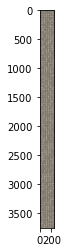

In [190]:
images, labels = next(iter(test_loader))

#  show some samples of data 

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225]) 
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) 
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
    
out = torchvision.utils.make_grid(images)

imshow(out)

In [191]:
import torch.nn.functional as F

# define the CNN model
class LeNetVariant(nn.Module):
    def __init__(self):
        super(LeNetVariant, self).__init__()
        self.features = nn.Sequential(
            # Convolutional layer #1.
            # Input image size 28x28x1
            # Computes 16 features using a 5x5 filter with ReLU activation.
            # Output image size 24x24x16
            # Pooling Layer #1.
            # First max pooling layer with a 2x2 filter and stride of 2.
            # Output image size 12x12x16
            nn.Conv2d(1, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # Convolutional layer #2.
            # Input image size 12x12x16
            # Computes 32 features using a 5x5 filter with ReLU activation.
            # Output image size 8x8x32
            # Pooling Layer #2.
            # Second max pooling layer with a 2x2 filter and stride of 2.
            # Output image size 4x4x32
            nn.Conv2d(16, 32, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # Dropout layer to prevent overfitting
            nn.Dropout2d()
        )
        # First Fully-Connected to create 32 vectors, each one with 32x4x4=512 length
        self.classifier = nn.Sequential(nn.Linear(32 * 4 * 4, 32))

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 32 * 4 * 4 )
        x = self.classifier(x)
        return x

# define the CNN+LSTM model
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNLSTM, self).__init__()
        self.cnn = LeNetVariant()
        # lstm layer
        # Input size 32x512
        # Output size 160
        self.lstm = nn.LSTM(input_size=32, hidden_size=160, num_layers=1,
                            batch_first=True)
        # Second Fully-Connected to create num_classes vectors, each one with 160 length
        self.fc1 = nn.Linear(160, num_classes)

    def forward(self, x_3d):
        cnn_output_list = list()
        for t in range(x_3d.size(1)):
            cnn_output_list.append(self.cnn(x_3d[:, t, :, :, :]))
        x = torch.stack(tuple(cnn_output_list), dim=1)
        out, hidden = self.lstm(x)
        x = out[:, -1, :]
        x = F.relu(x)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

In [156]:
# define the train steps
def train_loop(dataloader, model, loss_fn, optimizer, which_model):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Insert a dim at location of dim 1
        X = X.unsqueeze(1)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        

# define the test steps
def test_loop(dataloader, model, loss_fn, which_model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
        
            X = X.unsqueeze(1)
            pred = model(X)
            output_prob.append(pred.tolist())
            
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    loss_list.append(test_loss)
    accuracy_list.append(correct * 100)
    
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.2f}%, "
          f"Avg loss: {test_loss:>8f} \n")

In [185]:
# Start to train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNLSTM(num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


for t in range(num_epoches):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, 2)
    test_loop(test_loader, model, loss_fn, 2)
    print("Done!")
    
    
# Save Models
torch.save(model.state_dict(), "cnnlstm.pth")
print("Saved PyTorch Model State to cnnlstm.pth")

Epoch 1
-------------------------------
loss: 2.302471  [    0/60000]
loss: 1.203002  [50000/60000]
Test Error: 
 Accuracy: 58.67%, Avg loss: 1.151147 

Done!
Epoch 2
-------------------------------
loss: 1.135758  [    0/60000]
loss: 0.900739  [50000/60000]
Test Error: 
 Accuracy: 68.73%, Avg loss: 0.862048 

Done!
Epoch 3
-------------------------------
loss: 0.833617  [    0/60000]
loss: 0.757731  [50000/60000]
Test Error: 
 Accuracy: 72.77%, Avg loss: 0.728230 

Done!
Epoch 4
-------------------------------
loss: 0.713932  [    0/60000]
loss: 0.628232  [50000/60000]
Test Error: 
 Accuracy: 75.48%, Avg loss: 0.643462 

Done!
Epoch 5
-------------------------------
loss: 0.657227  [    0/60000]
loss: 0.573351  [50000/60000]
Test Error: 
 Accuracy: 77.65%, Avg loss: 0.592779 

Done!
Epoch 6
-------------------------------
loss: 0.569594  [    0/60000]
loss: 0.535896  [50000/60000]
Test Error: 
 Accuracy: 79.33%, Avg loss: 0.560739 

Done!
Epoch 7
-------------------------------
loss: 

loss: 0.300943  [50000/60000]
Test Error: 
 Accuracy: 88.36%, Avg loss: 0.314570 

Done!
Epoch 53
-------------------------------
loss: 0.250535  [    0/60000]
loss: 0.274820  [50000/60000]
Test Error: 
 Accuracy: 88.11%, Avg loss: 0.314309 

Done!
Epoch 54
-------------------------------
loss: 0.280491  [    0/60000]
loss: 0.274075  [50000/60000]
Test Error: 
 Accuracy: 88.73%, Avg loss: 0.302809 

Done!
Epoch 55
-------------------------------
loss: 0.268706  [    0/60000]
loss: 0.282077  [50000/60000]
Test Error: 
 Accuracy: 88.21%, Avg loss: 0.312266 

Done!
Epoch 56
-------------------------------
loss: 0.298318  [    0/60000]
loss: 0.272015  [50000/60000]
Test Error: 
 Accuracy: 88.89%, Avg loss: 0.305716 

Done!
Epoch 57
-------------------------------
loss: 0.289102  [    0/60000]
loss: 0.330839  [50000/60000]
Test Error: 
 Accuracy: 88.54%, Avg loss: 0.307765 

Done!
Epoch 58
-------------------------------
loss: 0.281965  [    0/60000]
loss: 0.273154  [50000/60000]
Test Error

In [245]:
# Compute the confusion matrix and F1_score, Acc, Recall_rate, and Precision

# Aggregated output is being used.
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    prob = torch.tensor(np.zeros((1,20)))
    with torch.no_grad():
        for data, target in test_loader:
    
            data = data.unsqueeze(1)
            # image flip
            data_h = TF.hflip(data)
            # output before and after image flip 
            output_o = model(data)
            output_h = model(data_h)
            # concat horizational into [1000,20]
            output = torch.cat((output_o,output_h),dim = 1)
            # return the label with highest prob among all classification results from two prespetives
            prediction = output.argmax(dim=1, keepdim=True)%10
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
            # record output probs of aggregated output for future tSNE plot
            prob = torch.cat((prob,output),dim = 0)

    return [i.item() for i in actuals], [i.item() for i in predictions], prob
 
actuals, predictions, probs = test_label_predictions(model, device, test_loader)
k = confusion_matrix(actuals, predictions)
print('Confusion matrix:')
print(k)
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))
print('Recall score: %f' % recall_score(actuals, predictions, average='micro'))
print('Precision score: %f' % precision_score(actuals, predictions, average='weighted'))

torch.Size([1001, 20])
torch.Size([2001, 20])
torch.Size([3001, 20])
torch.Size([4001, 20])
torch.Size([5001, 20])
torch.Size([6001, 20])
torch.Size([7001, 20])
torch.Size([8001, 20])
torch.Size([9001, 20])
torch.Size([10001, 20])
Confusion matrix:
[[849   0   9  24   8   1 106   0   3   0]
 [  0 979   0  11   3   1   4   0   2   0]
 [ 16   0 878   8  49   0  47   0   2   0]
 [ 13   2   6 932  27   0  19   0   0   1]
 [  2   1  43  25 888   0  40   0   1   0]
 [  0   0   0   0   0 974   0  16   0  10]
 [ 94   0  56  28  73   0 741   0   8   0]
 [  0   0   0   0   0  15   0 959   0  26]
 [  2   0   1   3   2   3   3   2 983   1]
 [  0   0   0   0   0   5   0  35   0 960]]
F1 score: 0.914300
Accuracy score: 0.914300
Recall score: 0.914300
Precision score: 0.914109


In [242]:

torch.tensor(np.zeros((1,20)))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)

In [12]:
np.shape(predictions)

(10000,)

In [246]:
np.shape(probs)

torch.Size([10001, 20])

In [14]:
out_prob = np.reshape(output_prob[(num_epoches-1)*10:num_epoches*10][:][:],(-1, 10))

In [15]:
np.shape(out_prob)

(10000, 10)

In [250]:
import pandas as pd
#out_prob = pd.DataFrame(out_prob)

In [251]:
probs = pd.DataFrame(probs)
probs.to_csv('probs_ag_LSTM.csv', sep = ',')

In [18]:
np.exp(out_prob).to_csv('output_prob_LSTM.csv', sep = ',')

In [19]:
print(classification_report(actuals, predictions))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.84      0.86      0.85      1000
           3       0.91      0.92      0.91      1000
           4       0.82      0.86      0.84      1000
           5       0.98      0.98      0.98      1000
           6       0.78      0.67      0.72      1000
           7       0.96      0.95      0.96      1000
           8       0.97      0.98      0.97      1000
           9       0.96      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.90      0.91      0.90     10000
weighted avg       0.90      0.91      0.90     10000



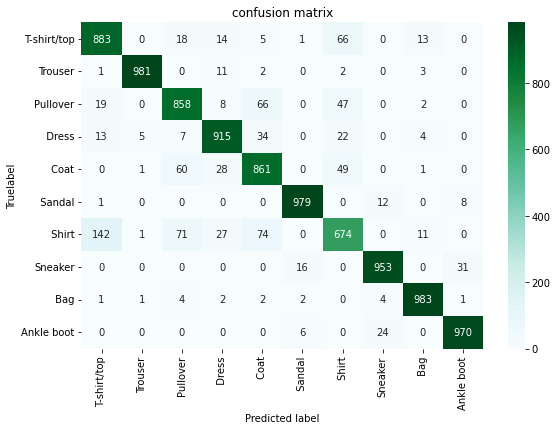

In [20]:
#draw the heatmap of confusion matrix

import pandas as pd
import seaborn as sns
# Display the confusion matrix as a heatmap
class_names = ['T-shirt/top', 'Trouser', 'Pullover', '  Dress', ' Coat', '  Sandal', ' Shirt', 'Sneaker', ' Bag', 'Ankle boot']
df_cm = pd.DataFrame(k, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Predicted label")
plt.ylabel("Truelabel")
plt.title("confusion matrix")
plt.show()

The area under the ROC curve: 0.972369


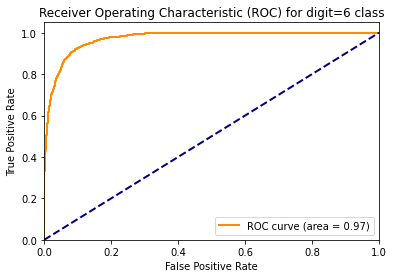

In [27]:
#check the ROC and AUROC of a class

import numpy as np


which_class = 6
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.unsqueeze(1)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            #setting the target tensor size to same as prediction tensor size
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

actuals, class_probabilities = test_class_probabilities(model, device, test_loader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr) #Compute the area under the ROC curve.
print('The area under the ROC curve: %f' % roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()
#plt.savefig("ROC.png")

In [22]:
# fashion_mnist = pymde.datasets.FashionMNIST()
# embedding = pymde.preserve_neighbors(fashion_mnist.data, verbose=True).embed()
# pymde.plot(embedding, color_by=mnist.attributes['class'])